Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create train dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create validation dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

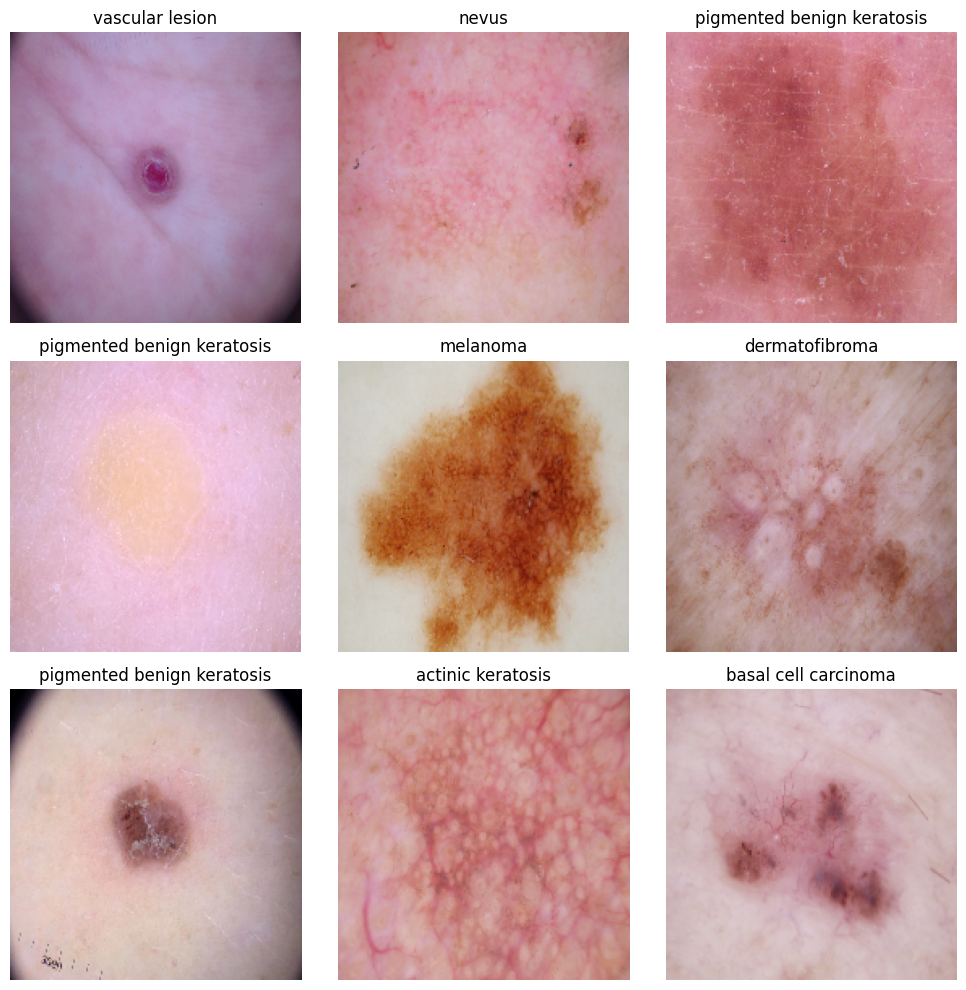

In [10]:
import matplotlib.pyplot as plt

# Visualize a batch of images
plt.figure(figsize=(10, 10))

# Take one batch of data from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):  # Visualize the first 9 images
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.title(class_names[labels[i]])
        plt.axis("off")  # Remove axis

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Total number of images based on the class / cateogories.
def class_distribution_count(directory):
    """
    Counts the number of images in each class within a given directory.

    Args:
        directory (str): Path to the directory containing class subdirectories.

    Returns:
        pd.DataFrame: A DataFrame containing class names and their corresponding image counts.
    """
    # Initialize lists for storing class names and image counts
    class_names = []
    image_counts = []

    # Iterate through the subdirectories
    for subdir in pathlib.Path(directory).iterdir():
        if subdir.is_dir():  # Check if it's a directory
            class_names.append(subdir.name)  # Store the class name (directory name)
            image_counts.append(len(list(subdir.glob("*.*"))))  # Count image files in the subdirectory

    # Return the data as a pandas DataFrame
    return pd.DataFrame({"Class": class_names, "No. of Images": image_counts})

# Example usage
df = class_distribution_count(data_dir_train)
df.head(10)


,Class,No. of Images
0,actinic keratosis,114
1,seborrheic keratosis,77
2,vascular lesion,139
3,basal cell carcinoma,376
4,nevus,357
5,squamous cell carcinoma,181
6,melanoma,438
7,pigmented benign keratosis,462
8,dermatofibroma,95


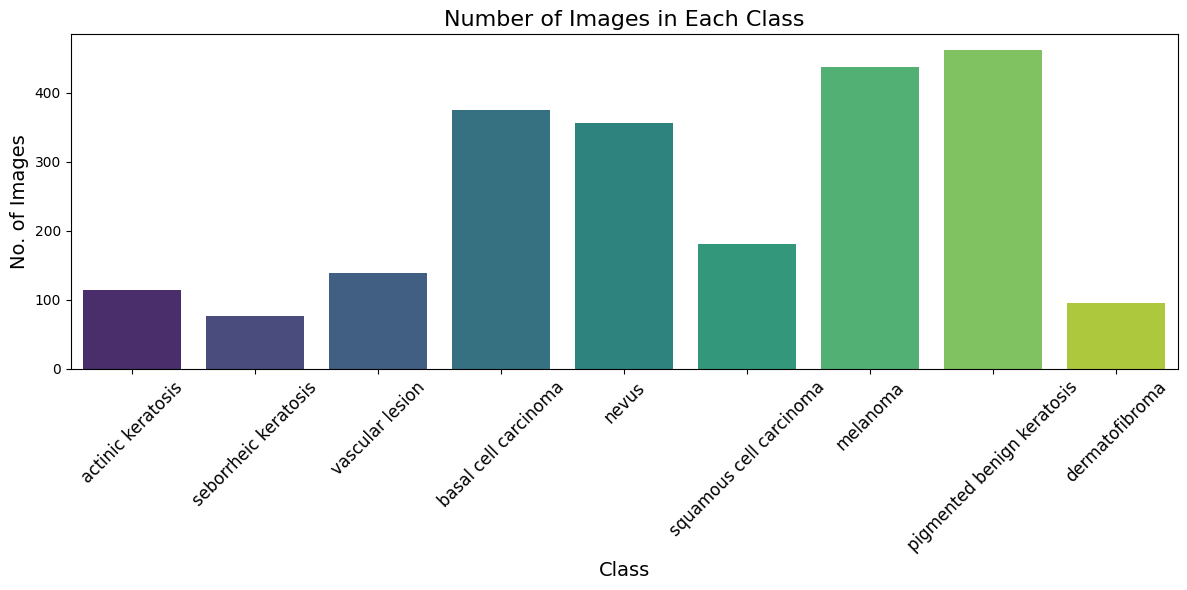

In [13]:
# Visualize the number of images in each class as a vertical bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="No. of Images", hue="Class", data=df, palette="viridis", dodge=False)
plt.title("Number of Images in Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate class names for better visibility
plt.legend([], [], frameon=False)  # Remove the legend since hue is redundant
plt.tight_layout()
plt.show()

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
target_classes = 9  # Number of target labels for classification

# Build CNN model
def create_model():

    model = Sequential([
        # Rescaling layer to normalize the images
        layers.Rescaling(1./255, input_shape=(180, 180, 3)),

        # First convolutional layer
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Second convolutional layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Third convolutional layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Dropout layer with 50% fraction
        layers.Dropout(0.5),

        # Flatten layer to convert 3D tensor to 1D tensor
        layers.Flatten(),

        # Fully connected (Dense) layer
        layers.Dense(128, activation='relu'),

        # Dropout layer with 25% fraction
        layers.Dropout(0.25),

        # Output layer with softmax activation for multi-class classification
        layers.Dense(target_classes, activation='softmax')
    ])

    return model

model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
# ### Todo, choose an appropirate optimiser and loss function
# model.compile(optimizer='your_optimser',
#               loss=your_loss_function_goes_here,
#               metrics=['accuracy'])
# Compile the model
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
## Your code goes here, note: train your model for 20 epochs
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 458s 3s/step - accuracy: 0.2277 - loss: 2.2417 - val_accuracy: 0.2819 - val_loss: 2.0290
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.3437 - loss: 1.8296 - val_accuracy: 0.4564 - val_loss: 1.6054
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4309 - loss: 1.5902 - val_accuracy: 0.4944 - val_loss: 1.5443
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4881 - loss: 1.5076 - val_accuracy: 0.5168 - val_loss: 1.4337
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5056 - loss: 1.3964 - val_accuracy: 0.5257 - val_loss: 1.3984
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5282 - loss: 1.3192 - val_accuracy: 0.5503 - val_loss: 1.3167
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5717 - loss: 1.2230 - val_accuracy: 0.5280 - val_loss: 1.4631
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5857 - loss: 1.1701 - val_accuracy: 0.5302 - 

### Visualizing training results

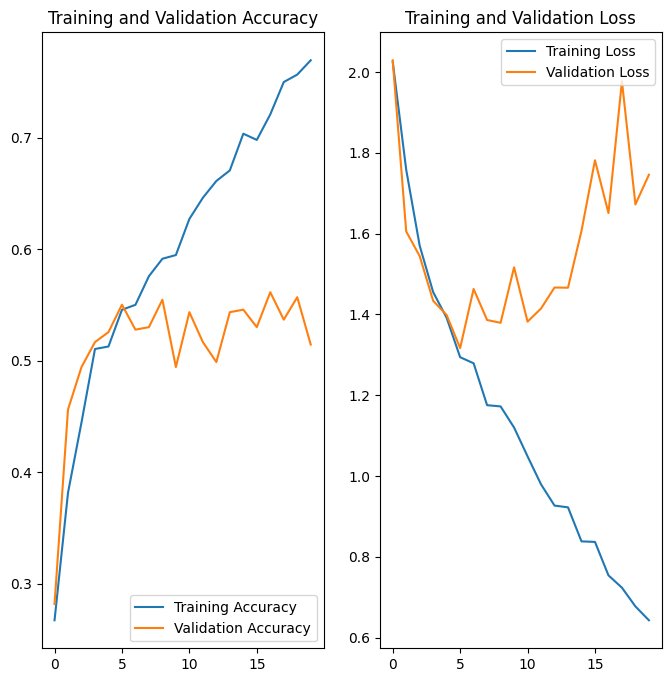

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Observations:

- The model demonstrates a consistent increase in training accuracy, reaching up to 77%, while the validation accuracy remains stable at approximately 53%.

- The substantial gap between training and validation accuracy indicates that the model has likely learned to fit the noise present in the training data, rather than generalizing well to unseen data. This suggests that overfitting may be occurring.

- To mitigate this issue, data augmentation techniques will be applied. Given the limited size of the training dataset, new samples will be generated by applying slight variations to the existing data, such as horizontal and vertical image flipping, minor rotations, and other transformations. These augmented samples will be used to train the model, with the goal of improving its generalizability.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

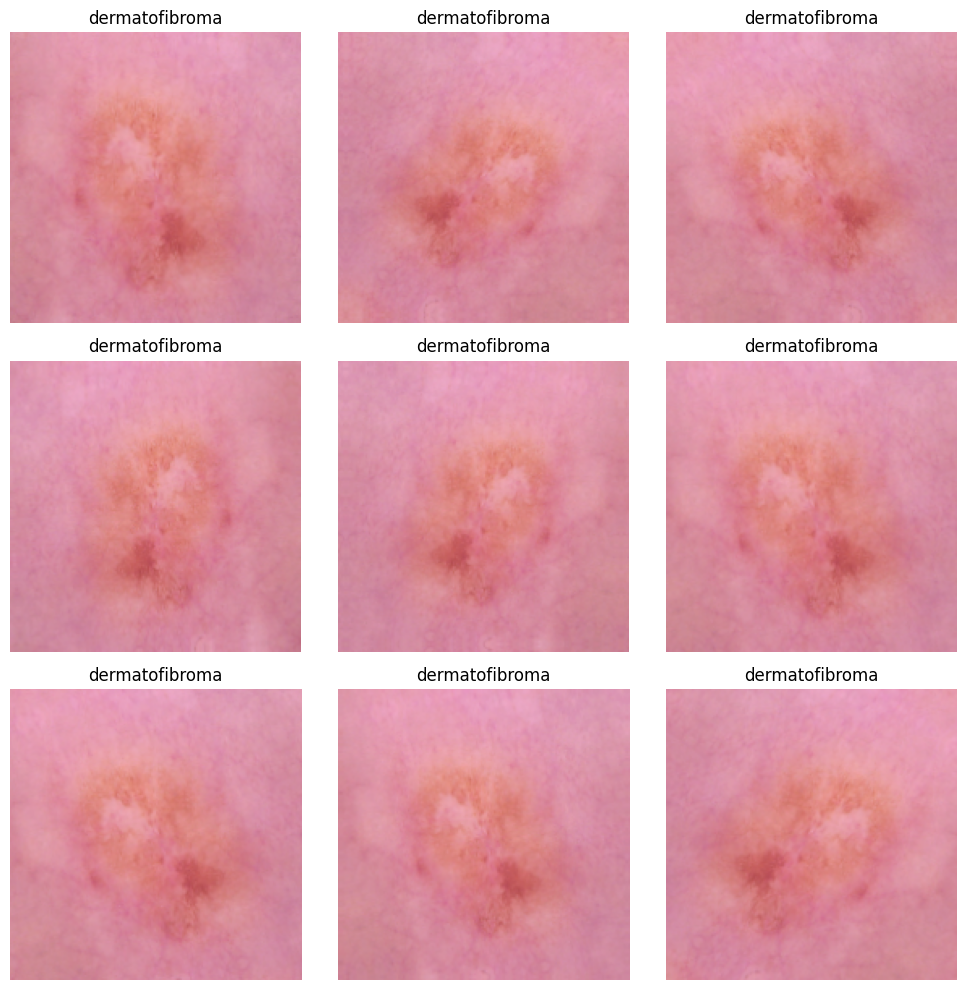

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Visualize augmented images
plt.figure(figsize=(10, 10))

# Take one batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):

        # Generate augmented images
        augmented_images = augmentation_data(images)

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0].numpy()])
        plt.axis("off")

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = tf.keras.Sequential([
    # Augmentation layer
    augmentation_data,

    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional block
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Second convolutional block
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Third convolutional block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Dropout layer to prevent overfitting
    layers.Dropout(0.2),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # Output layer with logits for multi-class classification
    layers.Dense(target_classes)
])



### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.2237 - loss: 2.0783 - val_accuracy: 0.3177 - val_loss: 1.7963
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3967 - loss: 1.6986 - val_accuracy: 0.4787 - val_loss: 1.4812
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4606 - loss: 1.4951 - val_accuracy: 0.5123 - val_loss: 1.4410
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5001 - loss: 1.4149 - val_accuracy: 0.5078 - val_loss: 1.3775
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5351 - loss: 1.3145 - val_accuracy: 0.4787 - val_loss: 1.4607
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5122 - loss: 1.3376 - val_accuracy: 0.4877 - val_loss: 1.4802
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5452 - loss: 1.3313 - val_accuracy: 0.5324 - val_loss: 1.3449
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5382 - loss: 1.2508 - val_accuracy: 0.5280 - v

### Visualizing the results

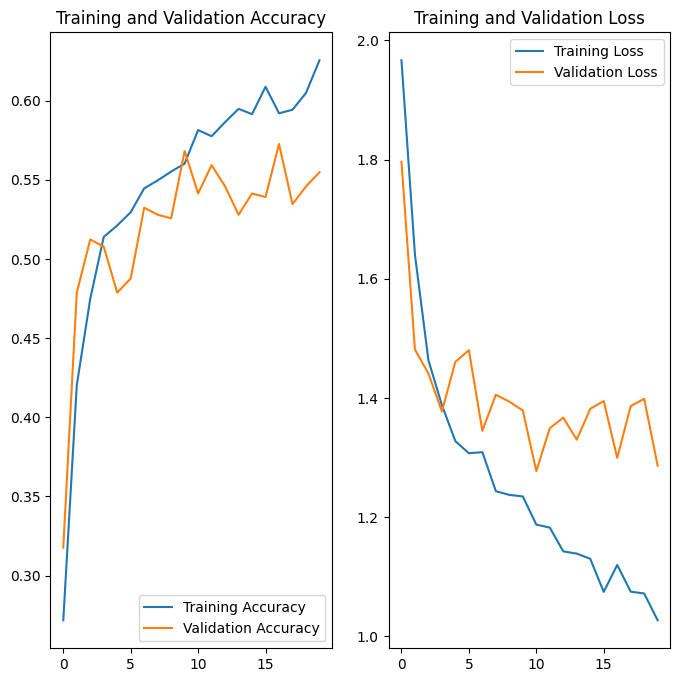

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Here are the findings below:

1. The implementation of data augmentation has effectively mitigated overfitting, improving the model's generalization. However, both the training and validation accuracy are currently within a similar range, indicating the presence of underfitting.
2. Despite the efforts to address overfitting, the model is not performing optimally on either the training or validation data. This suggests that the model is too simplistic or lacks the capacity to learn complex patterns in the data, which is typical in cases of underfitting.
3. Further adjustments, such as enhancing the model's architecture or training for more epochs, may be needed to improve performance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.

# Retrieve the image paths for all class labels (lesions)
image_paths = glob(os.path.join(data_dir_train, '*', '*.jpg'))

# Extract the class labels (lesions) from the directory structure
class_labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Print the total number of labels
print(f"Total number of class labels: {len(class_labels)}")

# Create a dictionary mapping image paths to class labels
image_to_label_mapping = {path: label for path, label in zip(image_paths, class_labels)}

# Print the first 5 entries in the dictionary
print("First 5 image-to-label mappings:")
print(list(image_to_label_mapping.items())[:5])

Total number of class labels: 2239
First 5 image-to-label mappings:
[('/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026171.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025992.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026194.jpg', 'actinic keratosis')]


In [26]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_to_label_mapping.items()), columns=['Path', 'Label'])
lesions_df.head()

,Path,Label
0,/content/drive/MyDrive/Colab Files/CNN_assignm...,actinic keratosis
1,/content/drive/MyDrive/Colab Files/CNN_assignm...,actinic keratosis
2,/content/drive/MyDrive/Colab Files/CNN_assignm...,actinic keratosis
3,/content/drive/MyDrive/Colab Files/CNN_assignm...,actinic keratosis
4,/content/drive/MyDrive/Colab Files/CNN_assignm...,actinic keratosis


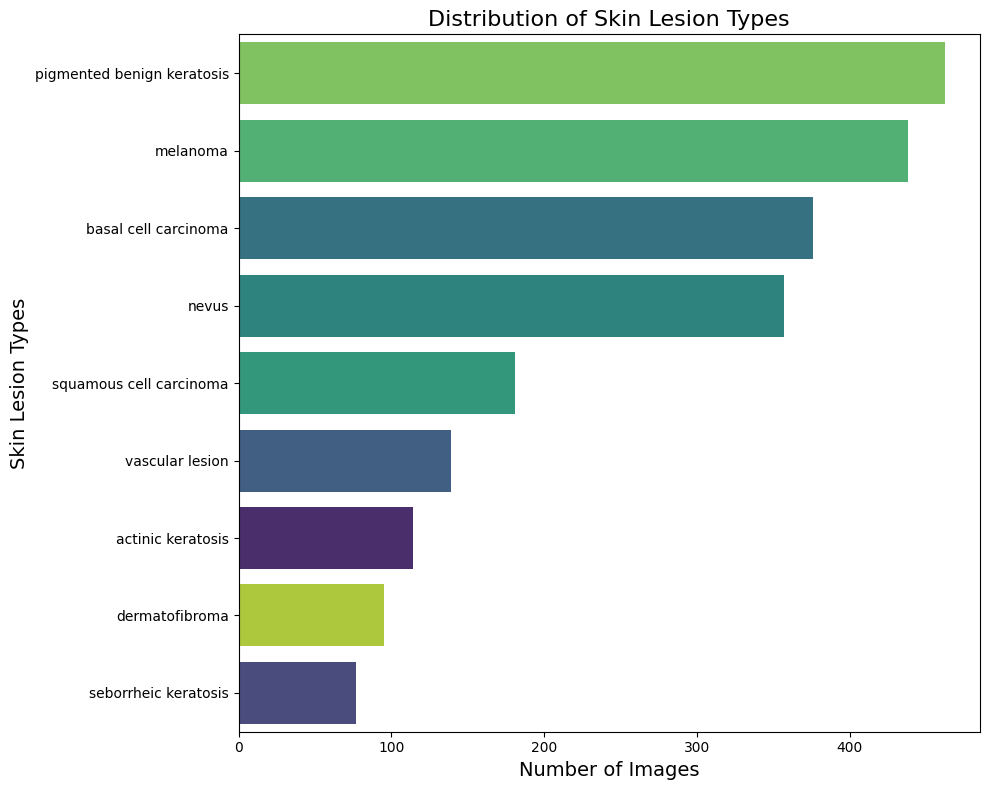

In [27]:
# Visualize the distribution of classes using a count plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.countplot(
    y='Label',
    hue="Label",
    data=lesions_df,
    order=lesions_df['Label'].value_counts().index,
    palette="viridis"  # Added a color palette
)
plt.title('Distribution of Skin Lesion Types', fontsize=16)
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.tight_layout()
plt.show()

In [28]:
# Inspect the distribution of classes in the dataset
class_distribution = lesions_df['Label'].value_counts()
print("Class distribution:")
print(class_distribution)

# Calculate and print the percentage distribution of each class
class_percentage = lesions_df[['Label']].value_counts(normalize=True) * 100
class_percentage_rounded = class_percentage.round(2)
print("\nClass percentage distribution:")
print(class_percentage_rounded)

Class distribution:
Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

Class percentage distribution:
Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64


#### **Todo:** Here are the findings below:
#### - Which class has the least number of samples?
 - Seborrheic keratosis has the least number of samples with 77 images.

#### - Which classes dominate the data in terms proportionate number of samples?
 - The classes that dominate in terms of proportionate number of samples are:
- Pigmented benign keratosis: 20.63% of the data.
- Melanoma: 19.56% of the data.
- Basal cell carcinoma: 16.79% of the data.
- Nevus: 15.94% of the data.

These four classes make up the largest proportion of the dataset, with the first two being the most dominant.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D9158DBB940>: 100%|██████████| 500/500 [00:29<00:00, 17.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D91E491FFA0>: 100%|██████████| 500/500 [00:19<00:00, 26.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9158E6D600>: 100%|██████████| 500/500 [00:21<00:00, 22.76 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D9158C41DE0>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9158C40790>: 100%|██████████| 500/500 [01:16<00:00,  6.50 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D918E5E86D0>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D9158D05E70>: 100%|██████████| 500/500 [00:42<00:00, 11.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9158E6D600>: 100%|██████████| 500/500 [00:19<00:00, 25.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D918E5EBD00>: 100%|██████████| 500/500 [00:20<00:00, 24.51 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_a8dfad9e-6faf-4d0e-9080-0ff709c722ce.jpg',
 '/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_1d018c95-ff76-4e63-b568-2ef934c17349.jpg',
 '/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_f8dc1bba-030f-4f4b-8b46-1a4e29118df3.jpg',
 '/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_bcbeca00-d7cb-4385-a3d1-37d7eb55be74.jpg',
 '/content/drive/MyDrive/Colab Files/CNN_assignment/Skin cancer ISIC The

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [36]:
# Inspecting the class distribution after adding 500 samples per label
class_counts = new_df['Label'].value_counts()
print("Class distribution after adding 500 samples per label:")
print(class_counts)

# Inspecting the class percentage distribution after adding 500 samples per label
class_percentage = new_df['Label'].value_counts(normalize=True) * 100
print("\nClass percentage distribution after adding 500 samples per label:")
print(round(class_percentage, 2))

Class distribution after adding 500 samples per label:
Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Class percentage distribution after adding 500 samples per label:
Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
# Create the model
model = Sequential([
    # Data Augmentation Layer
    augmentation_data,

    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    # Convolutional layers with ReLU activation
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Dropout to prevent overfitting
    layers.Dropout(0.2),

    # Flatten layer to convert 2D matrix into 1D vector
    layers.Flatten(),

    # Fully connected dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(target_classes)  # Output layer with the number of target classes
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [42]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is used to save the model or its weights at the point of the best validation accuracy
checkpoint = ModelCheckpoint(
    "model.keras",                    # Filepath for saving the model
    monitor="val_accuracy",           # Monitor validation accuracy during training
    save_best_only=True,              # Only save the best model based on the validation accuracy
    mode="max",                       # Save the model when validation accuracy is maximized
    verbose=1                          # Print updates when the model is saved
)

# EarlyStopping callback is used to stop training early if validation accuracy doesn't improve
earlystop = EarlyStopping(
    monitor="val_accuracy",           # Monitor validation accuracy
    patience=5,                        # Number of epochs with no improvement before stopping training
    mode="max",                        # Stop training when validation accuracy stops improving
    verbose=1                          # Print a message when training is stopped early
)

#### **Todo:**  Train your model

In [43]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.1677 - loss: 2.1807
Epoch 1: val_accuracy improved from -inf to 0.36971, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.1679 - loss: 2.1802 - val_accuracy: 0.3697 - val_loss: 1.6976
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3782 - loss: 1.6538
Epoch 2: val_accuracy improved from 0.36971 to 0.47142, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.3783 - loss: 1.6535 - val_accuracy: 0.4714 - val_loss: 1.4237
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4737 - loss: 1.3791
Epoch 3: val_accuracy improved from 0.47142 to 0.47810, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 237ms/step - accuracy: 0.4736 - loss: 1.3791 - val_accuracy: 0.4781 - val_loss: 1.3470
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.4989 - loss: 1.3151
Epoch 4: val_accuracy improved from 0.4

In [44]:
# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

#### **Todo:**  Visualize the model results

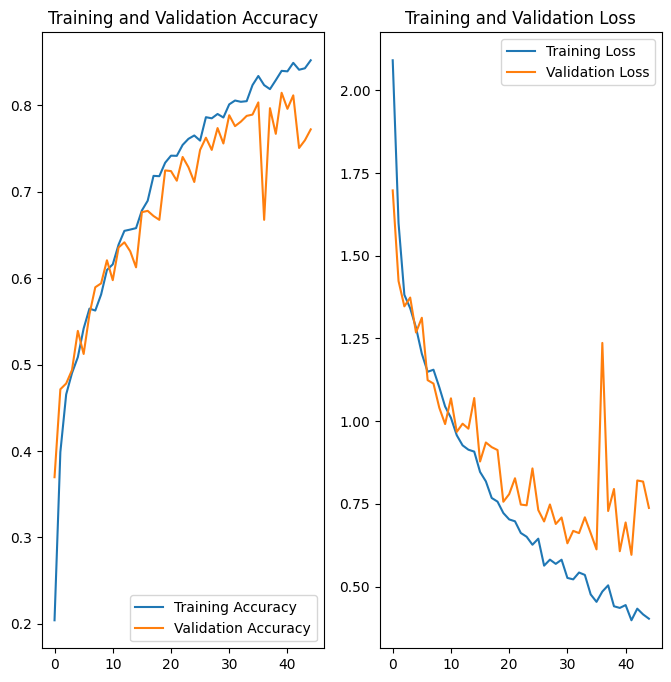

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



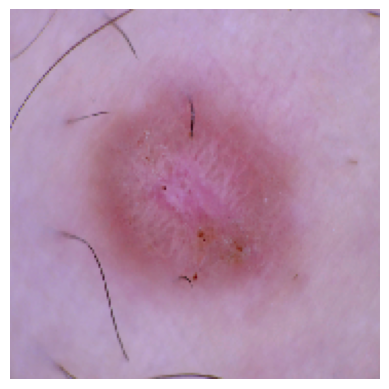

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: dermatofibroma
Predicted Class: dermatofibroma


In [47]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# Define the path for a test image from the specified class
image_path_test = os.path.join(data_dir_test, class_names[2], '*')

# Load the test image
test_image_paths = glob(image_path_test)
test_image = load_img(test_image_paths[-1], target_size=(180, 180))

# Display the test image
plt.imshow(test_image)
plt.axis('off')  # Hide grid
plt.show()

# Preprocess the image for prediction (expand dimensions to match input shape of the model)
img = np.expand_dims(test_image, axis=0)

# Make the prediction
predicted = model.predict(img)
predicted_class_index = np.argmax(predicted)

# Get the predicted class name
predicted_class = class_names[predicted_class_index]

# Print the actual and predicted classes
print(f"Actual Class: {class_names[2]}")
print(f"Predicted Class: {predicted_class}")
